In [1]:
import tensorflow as tf
import keras
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
from  keras.layers import Conv2D,Dropout,Flatten,Dense,MaxPooling2D,BatchNormalization
from keras.models import Sequential
from keras.regularizers import l2
from keras.callbacks import TensorBoard,EarlyStopping
import pandas as pd
from IPython.display import display
from sklearn.metrics import classification_report
from keras.utils import np_utils
import numpy as np
from keras.optimizers import Adam

# fashion-mnist pre-shuffled train and test data
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
labels = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
train_res = {}   
logdir = "logs/"
tensorboard_callback = TensorBoard(log_dir=logdir)
early_callback = EarlyStopping(monitor='val_loss', patience=15)

Using TensorFlow backend.


Fashion-mnist dataset sample


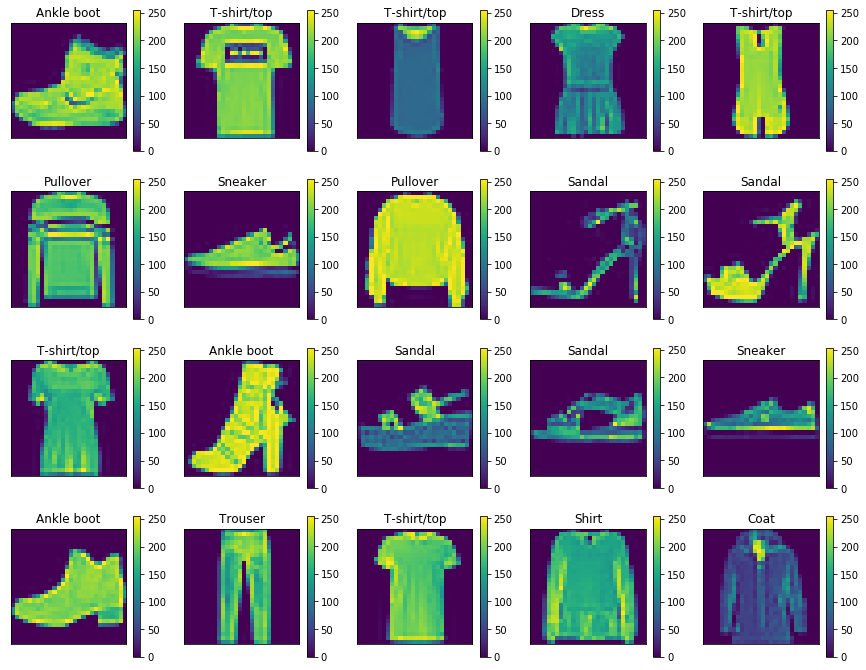

In [2]:
print("Fashion-mnist dataset sample")

plt.figure(figsize=(15,15))
for i in range(0,20):
    plt.subplot(5,5, i+1)
    plt.imshow(train_images[i] )
    plt.title( labels[train_labels[i]])
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.grid(False)
plt.show()

## **Pre-processing the data**

As part of pre-processing the data, following techniques were applied on the dataset:

#### 1). Create validation & test data sets
I split the train data(*60.000* samples) into *10.000* samples for the validation which is used for tuning the parameters of a model to ensure the model generalizing well. Model use *50.000* samples for training set and *10.000* for test data to evaluate model performance on unseen data.  

#### 2). Normalization
Images color data scales between 0-255 which is quite large, hence we should normalize image data to fit in scale 0-1 to to make our network easier to train.

#### 3). Reshaping images
We’ll reshape each image from (28, 28) to (28, 28, 1) because CNN requires the third dimension.


-----------------------------------------------------------------------------
Summary
train data:      (50000, 28, 28) , train data labels:       (50000,) 
test data:       (10000, 28, 28) , test data labels:        (10000,) 
validation data: (10000, 28, 28)  , validation data labels:  (10000,) 
-----------------------------------------------------------------------------

Standartized Input Images



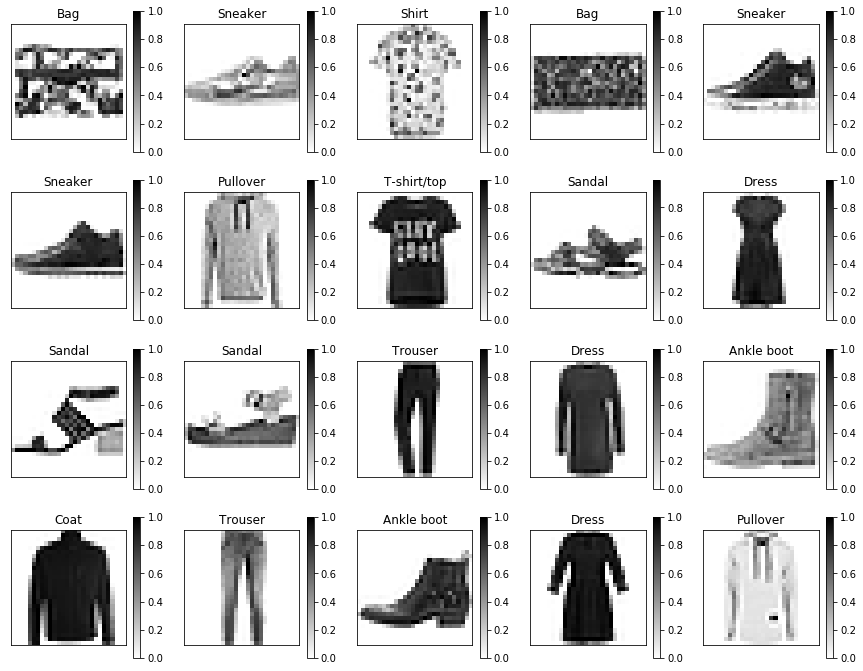

In [3]:
#splitting validation data
train_images, train_labels=train_images[10000:], train_labels[10000:]
valid_images, valid_labels=train_images[:10000], train_labels[:10000]


# [0-255] -> [0-1]
#train_images= tf.keras.utils.normalize(train_images,axis=1)
train_images= train_images / 255.0
test_images= test_images / 255.0
valid_images= valid_images  / 255.0

num_label_class = len(labels)

print()  
print("-----------------------------------------------------------------------------")    
print("Summary")    
print("train data:      %s , train data labels:       %s " % (train_images.shape, train_labels.shape))
print("test data:       %s , test data labels:        %s " % (test_images.shape, test_labels.shape))
print("validation data: %s  , validation data labels:  %s " % (valid_images.shape, valid_labels.shape)) 
print("-----------------------------------------------------------------------------")    
print()  
print("Standartized Input Images")
print()    

# Images color scale after normalization process:
plt.figure(figsize=(15,15))
for i in range(0,20):
    plt.subplot(5,5, i+1)
    plt.imshow(train_images[i],cmap=plt.cm.binary)
    plt.title( labels[train_labels[i]])
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.grid(False)
plt.show()    


train_images = train_images.reshape(train_images.shape[0],28,28,1)
test_images = test_images.reshape(test_images.shape[0],28,28,1)
valid_images = valid_images.reshape(valid_images.shape[0],28,28,1)



## CNN Model Architecture



### CNN Model 1 - 1Conv+1 FC+pooling+BN
- One Conv2D layer with 64 filter and 3x3 feature map size.
- MaxPooling2D,downsampling, to get the most important(max) information from each feature map.
- 1 fully-connected layer with 64 neurons. Adding a fully-connected(dense) layer before output layer is a common usage since dense layer classify images based on the high features extracted by previous layer. 
- 1 output layer with a softmax activation function to obtain classification probabilities(total sum of the probabilities of 10 classes equals to one)


In [15]:
cnn_model_1 = Sequential([Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)),
                          BatchNormalization(),
                          MaxPooling2D(pool_size=2),
                          Flatten(),
                          Dense(64, activation='relu'),
                          BatchNormalization(),
                          Dense(10, activation='softmax')],
                          name="CNN Model 1")
cnn_model_1.summary()

Model: "CNN Model 1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                692288    
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dense_8 (Dense)              (None, 10)                

### CNN Model 2 - 3Conv+1 FC+pooling+BN

- 1 Conv2D input layer with 64 filter and 3x3 feature map size.  
- 1 Conv2D layer with  filter=64.
- 1 Conv2D layer with  filter=128.
- 1 MaxPooling(2)
- 1 dense layer with 128 neurons. Best pratice to determine dense layer neuron number is to equalize the number of the latest convolutional layer neurons. 
- 1 output layer

In [16]:
cnn_model_2 = Sequential([Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)),
                          BatchNormalization(),
                          Conv2D(64, kernel_size=3, activation='relu'),
                          MaxPooling2D(pool_size=2),
                          Conv2D(128, kernel_size=3, activation='relu'),                          
                          MaxPooling2D(pool_size=2),
                          
                          Flatten(),
                          Dense(128, activation='relu'),
                          BatchNormalization(),
                          Dense(10, activation='softmax')],
                          name="CNN Model 2")
cnn_model_2.summary()

Model: "CNN Model 2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization_3 (Batch (None, 26, 26, 64)        256       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 10, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3200)              

 ### Compile
Since the target labels are integers(0 - T-shirt/top, 1 -Trouser etc) , I use sparse_categorical_crossentropy and Adam optimization algorithm with default learning rate(0.0001) which is pretty stable.


In [17]:
cnn_model_1.compile(loss='sparse_categorical_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])

cnn_model_2.compile(loss='sparse_categorical_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])



### Train

In [18]:
batch_size=64
epochs=10

train_res["CNN Model 1"] = cnn_model_1.fit(train_images,train_labels ,batch_size=batch_size,
                           epochs=epochs, validation_data=(valid_images,valid_labels),
                           verbose=2)
print("-----------------------------------------------------------------------------------------")
train_res["CNN Model 2"] = cnn_model_2.fit(train_images,train_labels ,batch_size=batch_size,
                           epochs=epochs, validation_data=(valid_images,valid_labels),
                           verbose=2)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
 - 27s - loss: 0.3627 - accuracy: 0.8722 - val_loss: 0.3481 - val_accuracy: 0.8819
Epoch 2/10
 - 26s - loss: 0.2455 - accuracy: 0.9105 - val_loss: 0.2277 - val_accuracy: 0.9188
Epoch 3/10
 - 27s - loss: 0.1994 - accuracy: 0.9272 - val_loss: 0.1622 - val_accuracy: 0.9386
Epoch 4/10
 - 26s - loss: 0.1687 - accuracy: 0.9385 - val_loss: 0.1852 - val_accuracy: 0.9321
Epoch 5/10
 - 26s - loss: 0.1447 - accuracy: 0.9472 - val_loss: 0.1409 - val_accuracy: 0.9480
Epoch 6/10
 - 26s - loss: 0.1248 - accuracy: 0.9545 - val_loss: 0.0972 - val_accuracy: 0.9678
Epoch 7/10
 - 26s - loss: 0.1039 - accuracy: 0.9621 - val_loss: 0.0938 - val_accuracy: 0.9649
Epoch 8/10
 - 26s - loss: 0.0881 - accuracy: 0.9686 - val_loss: 0.0728 - val_accuracy: 0.9746
Epoch 9/10
 - 26s - loss: 0.0796 - accuracy: 0.9703 - val_loss: 0.0630 - val_accuracy: 0.9793
Epoch 10/10
 - 26s - loss: 0.0666 - accuracy: 0.9761 - val_loss: 0.0701 - val_accuracy: 0.9737
---------

In [19]:
test_loss_1, test_acc_1  = cnn_model_1.evaluate(test_images,test_labels, verbose=2)
train_loss_1, train_acc_1  = cnn_model_1.evaluate(train_images,train_labels, verbose=2)
val_loss_1, val_acc_1  =  cnn_model_1.evaluate(valid_images,valid_labels, verbose=2)

test_loss_2, test_acc_2  = cnn_model_2.evaluate(test_images,test_labels, verbose=2)
train_loss_2, train_acc_2  = cnn_model_2.evaluate(train_images,train_labels, verbose=2)
val_loss_2, val_acc_2  =  cnn_model_2.evaluate(valid_images,valid_labels, verbose=2)

df = pd.DataFrame([[train_loss_1 * 100, val_loss_1 * 100, test_loss_1 * 100,train_acc_1 * 100,
                    val_acc_1 * 100, test_acc_1 * 100],
                  [train_loss_2 * 100 , val_loss_2 * 100, test_loss_2 * 100,train_acc_2 * 100,
                   val_acc_2 * 100, test_acc_2 * 100]],
                 ["1 Conv + 1 FC + pooling", "3 Conv+ 1 FC + pooling"],
                 ["Train Loss", "Validation Loss","Test Loss",
                 "Train Accuracy", "Validation Accuracy","Test Accuracy"])
display(df)

,Train Loss,Validation Loss,Test Loss,Train Accuracy,Validation Accuracy,Test Accuracy
1 Conv + 1 FC + pooling,7.230013,7.007776,34.984184,97.294003,97.369999,90.179998
3 Conv+ 1 FC + pooling,5.875246,6.064282,34.425357,97.832000,97.780001,91.000003


**CNN Model 1** accuracy on test set is **~%90**. My goal is achieving better accuracy. More convolution layers added to 'CNN Model 2' to extract more features. Hence, **CNN Model 2** accuracy is **~%91** , that can be said there is positive correlation between adding more convoluiton layers and accuracy increasing for this case.

Validation accuracy of Model 2 is higher than training accuracy (~6-7). This shows that it performs much better on the training set than test dataset. CNN models are prone to **over-fitting** which means that model memorize what it should do with each input instead of learning the general concepts of the data. It may detectable by observing big difference between validation and training loss or test accuracy is much lower than training accuracy.

Further models using different regularization techniques to prevent over-fitting.
* dropout
* l2 
- Also batch normalization has some regularization effect.



### CNN Model 3 - 3Conv+1FC+pooling+dropout+BN

- 1 Conv2D input layer with 64 filter and 3x3 feature map size.
- 1 Conv2D layer with filter=64.
- 1 MaxPooling(2)
- Dropout(0.3)
  Max Pooling down sample input representation. Dropout is after the pooling process to reduce unnecessary feature dependencies in the network and improves its generalization abilities
- 1 Conv2D layer with filter=128.
- 1 MaxPooling(2)
- Dropout(0.5)
- 1 Fc with 128 neuorons
- Dropout(0.5)
- 1 output layer

In [40]:
cnn_model_3 = Sequential([Conv2D(64, kernel_size=3, activation='relu',input_shape=(28,28,1)),
                          BatchNormalization(),
                          
                          Conv2D(64, kernel_size=3, activation='relu'),
                          MaxPooling2D(pool_size=2),
                          Dropout(0.3),
                          
                          Conv2D(128, kernel_size=3, activation='relu'),    
                          BatchNormalization(),
                          Dropout(0.5),

                          Flatten(),
                          Dense(128, activation='relu'),
                          BatchNormalization(),
                          Dropout(0.5),
                          Dense(10, activation='softmax')
                         ],name="CNN Model 3") 

cnn_model_3.summary()

Model: "CNN Model 3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization_14 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 10, 10, 128)       73856     
_________________________________________________________________
batch_normalization_15 (Batc (None, 10, 10, 128)       



### CNN Model 4 - 3Conv+1FC+pooling+l2+BN

 Model 4 uses l2 regularization technique to prevent over-fitting.
- 1 Conv2D input layer with 64 filter and 3x3 feature map size.
- 1 Conv2D layer with filter=64.
- 1 MaxPooling(2)
- 1 Conv2D layer with filter=128.
- 1 MaxPooling(2)
- 1 Fc with 128 neuorons
- 1 output layer


In [21]:
Regularizer = l2(0.001)
cnn_model_4 = Sequential([Conv2D(64, kernel_size=3, activation='relu',padding='same',
                                 kernel_regularizer=Regularizer, input_shape=(28,28,1)),
                          BatchNormalization(),
                          Conv2D(64, kernel_size=3, padding='same',
                                 kernel_regularizer=Regularizer, activation='relu'),
                          MaxPooling2D(pool_size=2),
                          Conv2D(128, kernel_size=3, padding='same',
                                 kernel_regularizer=Regularizer, activation='relu'),
                          BatchNormalization(),
                          Flatten(),
                          Dense(128, activation='relu'), 
                          BatchNormalization(),
                          Dense(10, activation='softmax')
                         ],name="CNN Model 4") 



print()
cnn_model_4.summary()


Model: "CNN Model 4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_8 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
batch_normalization_9 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
flatten_7 (Flatten)          (None, 25088)            

### Compile & Train

In [41]:
batch_size=64
epochs=10

cnn_model_3.compile(loss='sparse_categorical_crossentropy',
                       optimizer='adam',
                      metrics=['accuracy'])


train_res["CNN Model 3"] = cnn_model_3.fit(train_images,train_labels ,batch_size=batch_size,
                          epochs=epochs, validation_data=(valid_images,valid_labels),
                         verbose=2,shuffle=True,callbacks=[tensorboard_callback] )

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
 - 89s - loss: 0.5087 - accuracy: 0.8225 - val_loss: 0.2993 - val_accuracy: 0.8902
Epoch 2/10
 - 90s - loss: 0.3360 - accuracy: 0.8794 - val_loss: 0.2645 - val_accuracy: 0.8991
Epoch 3/10
 - 92s - loss: 0.2944 - accuracy: 0.8941 - val_loss: 0.2339 - val_accuracy: 0.9161
Epoch 4/10
 - 92s - loss: 0.2654 - accuracy: 0.9049 - val_loss: 0.1885 - val_accuracy: 0.9300
Epoch 5/10
 - 91s - loss: 0.2434 - accuracy: 0.9114 - val_loss: 0.1661 - val_accuracy: 0.9383
Epoch 6/10
 - 91s - loss: 0.2304 - accuracy: 0.9172 - val_loss: 0.1804 - val_accuracy: 0.9308
Epoch 7/10
 - 92s - loss: 0.2142 - accuracy: 0.9228 - val_loss: 0.1510 - val_accuracy: 0.9428
Epoch 8/10
 - 91s - loss: 0.2036 - accuracy: 0.9257 - val_loss: 0.1422 - val_accuracy: 0.9489
Epoch 9/10
 - 91s - loss: 0.1911 - accuracy: 0.9306 - val_loss: 0.1267 - val_accuracy: 0.9531
Epoch 10/10
 - 90s - loss: 0.1877 - accuracy: 0.9307 - val_loss: 0.1229 - val_accuracy: 0.9545


In [23]:
cnn_model_4.compile(loss='sparse_categorical_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])


train_res["CNN Model 4"] = cnn_model_4.fit(train_images,train_labels ,batch_size=batch_size,
                           epochs=epochs, validation_data=(valid_images,valid_labels),
                           verbose=2,shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
 - 124s - loss: 0.4510 - accuracy: 0.8790 - val_loss: 0.3522 - val_accuracy: 0.9048
Epoch 2/10
 - 123s - loss: 0.2928 - accuracy: 0.9161 - val_loss: 0.2364 - val_accuracy: 0.9338
Epoch 3/10
 - 126s - loss: 0.2366 - accuracy: 0.9316 - val_loss: 0.2360 - val_accuracy: 0.9329
Epoch 4/10
 - 128s - loss: 0.2043 - accuracy: 0.9408 - val_loss: 0.1802 - val_accuracy: 0.9502
Epoch 5/10
 - 129s - loss: 0.1746 - accuracy: 0.9521 - val_loss: 0.1540 - val_accuracy: 0.9603
Epoch 6/10
 - 127s - loss: 0.1493 - accuracy: 0.9599 - val_loss: 0.1914 - val_accuracy: 0.9481
Epoch 7/10
 - 127s - loss: 0.1255 - accuracy: 0.9696 - val_loss: 0.1126 - val_accuracy: 0.9737
Epoch 8/10
 - 131s - loss: 0.1057 - accuracy: 0.9758 - val_loss: 0.1397 - val_accuracy: 0.9631
Epoch 9/10
 - 131s - loss: 0.0894 - accuracy: 0.9812 - val_loss: 0.0810 - val_accuracy: 0.9853
Epoch 10/10
 - 133s - loss: 0.0816 - accuracy: 0.9831 - val_loss: 0.0850 - val_accuracy: 0.9815

### Evaluate

In [24]:
test_loss_3, test_acc_3  = cnn_model_3.evaluate(test_images,test_labels, verbose=2)
train_loss_3, train_acc_3  = cnn_model_3.evaluate(train_images,train_labels, verbose=2)
val_loss_3, val_acc_3  =  cnn_model_3.evaluate(valid_images,valid_labels, verbose=2)

test_loss_4, test_acc_4  = cnn_model_4.evaluate(test_images,test_labels, verbose=2)
train_loss_4, train_acc_4  = cnn_model_4.evaluate(train_images,train_labels, verbose=2)
val_loss_4, val_acc_4  =  cnn_model_4.evaluate(valid_images,valid_labels, verbose=2)


df = pd.DataFrame([[train_loss_3 * 100, val_loss_3 * 100, test_loss_3 * 100,train_acc_3 * 100,val_acc_3 * 100,
                    test_acc_3 * 100],
                  [train_loss_4 * 100 , val_loss_4 * 100, test_loss_4 * 100,train_acc_4 * 100,val_acc_4 * 100,
                    test_acc_4 * 100]],
                 ["Dropout", "L2 Regularization"], ["Train Loss", "Validation Loss","Test Loss",
                                                  "Train Accuracy", "Validation Accuracy","Test Accuracy"])
display(df)


,Train Loss,Validation Loss,Test Loss,Train Accuracy,Validation Accuracy,Test Accuracy
Dropout,11.358519,11.283514,20.494044,95.959997,95.880002,92.699999
L2 Regularization,8.611189,8.495091,36.385078,98.114002,98.150003,91.420001


From the results of different regularization techniques, the best accuracy is arrived **%92.6** by dropout regularization. The training and test accuracies are now more similar than before. The training accuracy decreased from **%97**  to **~%95** and test accuracy increased from **%90** to **%92** which means that overfitting is much less of a problem than before.

As we know, adding layers extract more features and let model to judge more precise but each CNN model has some level that adding more convolution layers does not mean more accuracy. CNN Model 5 checks if it is possible to increase accuracy if we add new layers.

### CNN Model 5 - 4Conv+2FC+pooling+dropout+BN

- 1 Conv2D input layer with 32 filter and 3x3 feature map size.
- 1 Conv2D layer with filter=32.
- 1 MaxPooling(2)
- Dropout(0.5)
- 1 Conv2D layer with filter=64.
- 1 MaxPooling(2)
- Dropout(0.5)
- 1 Conv2D layer with filter=128.
- 1 MaxPooling(2)
- 1 Conv2D layer with filter=256.
- 1 MaxPooling(2)
- Dropout(0.5)
- 1 FC with=256
- Dropout(0.5)
- 1 output layer

In [25]:
cnn_model_5 = Sequential([Conv2D(64, kernel_size=3, activation='relu',input_shape=(28,28,1)),
                          BatchNormalization(),
                          Conv2D(64, kernel_size=3, activation='relu'),
                          MaxPooling2D(pool_size=2),
                          Dropout(0.25),
                          
                          Conv2D(128, kernel_size=3, activation='relu'),
                          BatchNormalization(),
                          Dropout(0.5),

                          Conv2D(256, kernel_size=3, activation='relu'),
                          MaxPooling2D(pool_size=2),
                          Dropout(0.5),
                          
                          Flatten(),
                          Dense(256, activation='relu'),
                          BatchNormalization(),
                          Dropout(0.5),
                          Dense(10, activation='softmax')
                         ],name="CNN Model 5") 


cnn_model_5.compile(loss='sparse_categorical_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])


train_res["CNN Model 5"] = cnn_model_5.fit(train_images,train_labels ,batch_size=batch_size,
                           epochs=epochs, validation_data=(valid_images,valid_labels),callbacks=[early_callback],
                           verbose=2,shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
 - 103s - loss: 0.6024 - accuracy: 0.7831 - val_loss: 0.3741 - val_accuracy: 0.8611
Epoch 2/10
 - 105s - loss: 0.3828 - accuracy: 0.8614 - val_loss: 0.3041 - val_accuracy: 0.8886
Epoch 3/10
 - 106s - loss: 0.3346 - accuracy: 0.8784 - val_loss: 0.2675 - val_accuracy: 0.9024
Epoch 4/10
 - 107s - loss: 0.3058 - accuracy: 0.8902 - val_loss: 0.2751 - val_accuracy: 0.8975
Epoch 5/10
 - 107s - loss: 0.2858 - accuracy: 0.8977 - val_loss: 0.2383 - val_accuracy: 0.9130
Epoch 6/10
 - 136s - loss: 0.2701 - accuracy: 0.9008 - val_loss: 0.2176 - val_accuracy: 0.9266
Epoch 7/10
 - 150s - loss: 0.2591 - accuracy: 0.9078 - val_loss: 0.2055 - val_accuracy: 0.9257
Epoch 8/10
 - 102s - loss: 0.2473 - accuracy: 0.9113 - val_loss: 0.1827 - val_accuracy: 0.9343
Epoch 9/10
 - 109s - loss: 0.2361 - accuracy: 0.9135 - val_loss: 0.1799 - val_accuracy: 0.9357
Epoch 10/10
 - 113s - loss: 0.2287 - accuracy: 0.9175 - val_loss: 0.1770 - val_accuracy: 0.9361

In [26]:
test_loss_5, test_acc_5  = cnn_model_5.evaluate(test_images,test_labels, verbose=2)
train_loss_5, train_acc_5  = cnn_model_5.evaluate(train_images,train_labels, verbose=2)
val_loss_5, val_acc_5  =  cnn_model_5.evaluate(valid_images,valid_labels, verbose=2)

In [29]:

df = pd.DataFrame([[train_loss_1 * 100, val_loss_1 * 100, test_loss_1 * 100,train_acc_1 * 100,val_acc_1 * 100,
                    test_acc_1 * 100],
                   [train_loss_2 * 100, val_loss_2 * 100, test_loss_2 * 100,train_acc_2 * 100,val_acc_2 * 100,
                    test_acc_2 * 100],  
                    [train_loss_3 * 100, val_loss_3 * 100, test_loss_3 * 100,train_acc_3 * 100,val_acc_3 * 100,
                    test_acc_3 * 100],
                  [train_loss_4 * 100 , val_loss_4 * 100, test_loss_4 * 100,train_acc_4 * 100,val_acc_4 * 100,
                    test_acc_4 * 100],
                  [train_loss_5 * 100, val_loss_5 * 100, test_loss_5 * 100,train_acc_5 * 100,val_acc_5 * 100,
                    test_acc_5 * 100],
                       
                  ],
                 ["1Conv+1 FC+pooling", "3Conv+1 FC+pooling","3Conv+1FC+pooling+dropout",
                  "3Conv+1FC+pooling+l2","4Conv+2FC+pooling+dropout"],
                  ["Train Loss", "Validation Loss","Test Loss", "Train Accuracy",
                   "Validation Accuracy","Test Accuracy"])
display(df)



,Train Loss,Validation Loss,Test Loss,Train Accuracy,Validation Accuracy,Test Accuracy
1Conv+1 FC+pooling,7.230013,7.007776,34.984184,97.294003,97.369999,90.179998
3Conv+1 FC+pooling,5.875246,6.064282,34.425357,97.832000,97.780001,91.000003
3Conv+1FC+pooling+dropout,11.358519,11.283514,20.494044,95.959997,95.880002,92.699999
3Conv+1FC+pooling+l2,8.611189,8.495091,36.385078,98.114002,98.150003,91.420001
4Conv+2FC+pooling+dropout,17.294536,17.702973,22.687080,93.900001,93.610001,91.790003


First we started with a basic model and added more convolution layers. Deeper CNN model means more specific and intricate judgement. Adding more convolution layers provided a significant benefit for CNN Model 2. Having three convolution layers ascending filter number order, increased accuracy to **%92** which was expected because it helps network to extract more features rather than 1 convolution layers. After examining the validation accuracy and loss, we understood that the model is overfitting. When our model started over-fitting, we stopped adding new layers and used dropout&l2 regularization to overcome the problem. Its observable that dropout regularization helped to reduce the gap between training  and validation values which means that overfitting is much less of a problem than before. CNN Model 5(4Conv+2FC+pooling+dropout) accuracy is lower than CNN Model 3(3Conv+1FC+pooling+dropout).

The base model have ;
- 3 Convolution layer
- 1 Fully-connected layer
- MaxPooling
- BatchNormalization
- dropout	 


In [30]:
#prediction
predictions = cnn_model_3.predict(test_images)
test_labels_vec = np_utils.to_categorical(test_labels, 10)

# classification_report
print(classification_report(test_labels_vec.argmax(axis=-1), predictions.argmax(axis=1),target_names=labels))

              precision    recall  f1-score   support

 T-shirt/top       0.91      0.87      0.89      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.87      0.92      0.89      1000
       Dress       0.93      0.92      0.92      1000
        Coat       0.85      0.93      0.89      1000
      Sandal       0.97      0.99      0.98      1000
       Shirt       0.82      0.75      0.78      1000
     Sneaker       0.97      0.95      0.96      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.97      0.97      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



The best accuracy is obtained for Trouser, Sandal, Sneaker, Ankle boot. We can see that our model predicted less than 85% of shirts correctly out of the total.

Let's visualize some incorrectly classified images.

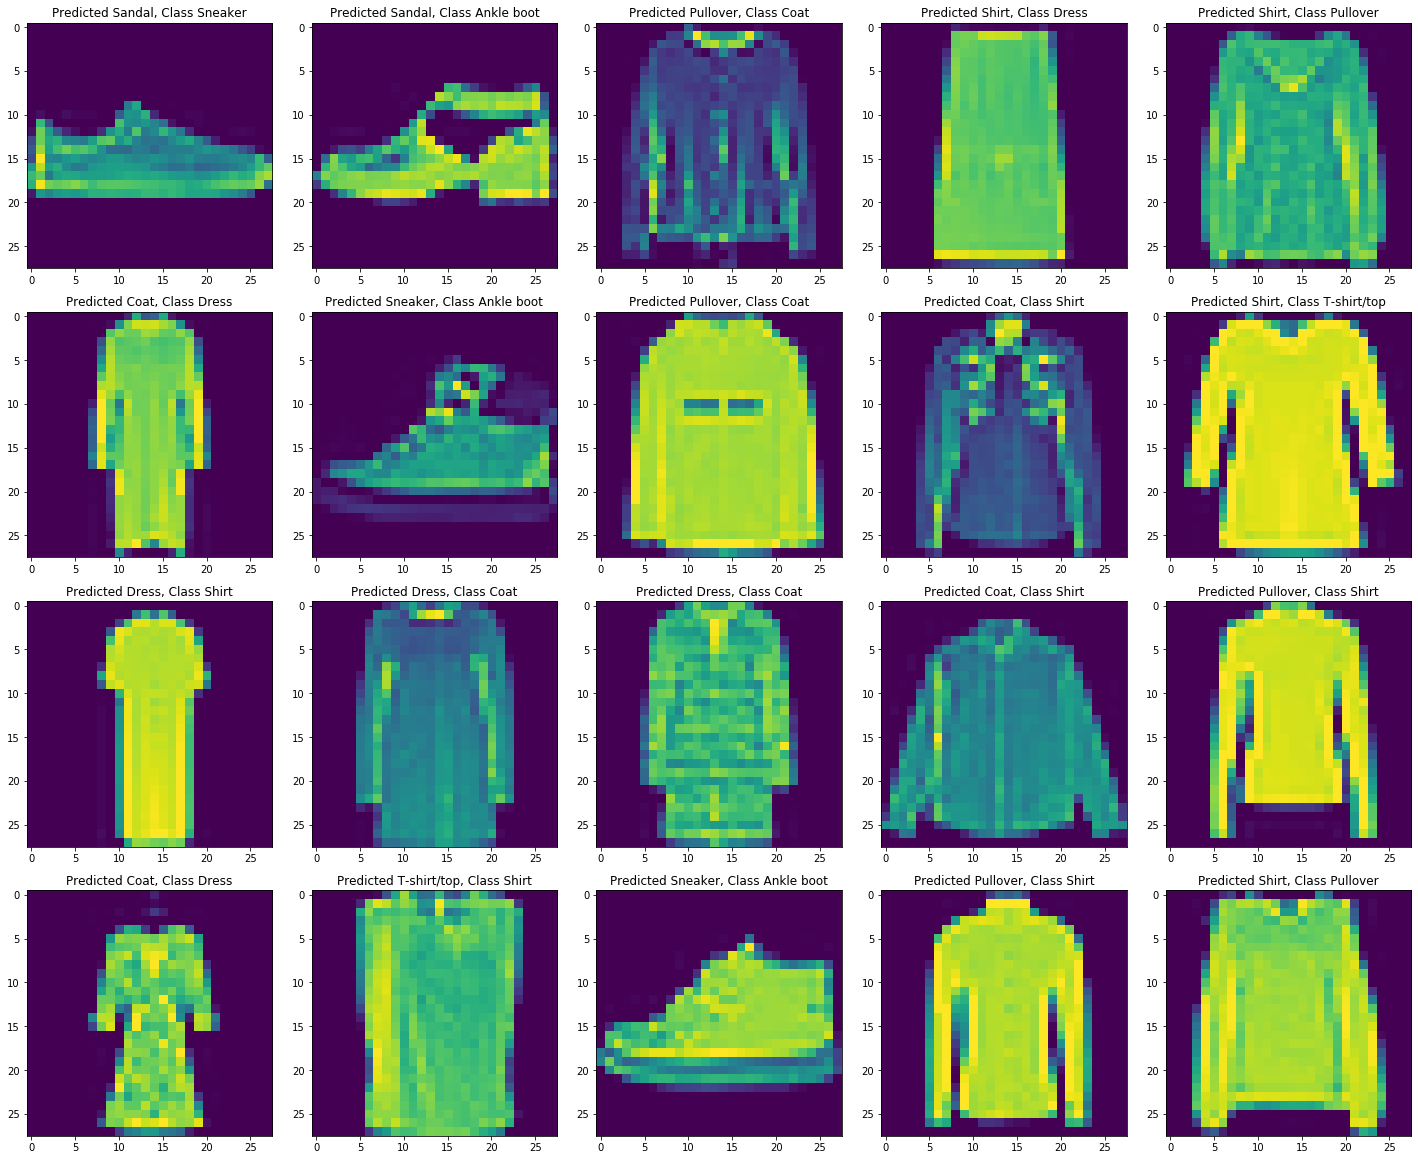

In [31]:
# Incorrect predictions and real labels
corrects = np.nonzero(np.argmax(predictions, axis=1)==test_labels)[0]
incorrects = np.nonzero(np.argmax(predictions, axis=1)!=test_labels)[0]

plt.figure(figsize=(20,20))
for i, incorrect in enumerate(incorrects[0:20]):
    plt.subplot(5,5,i+1)
    plt.imshow(test_images[incorrect].reshape(28,28))
    plt.title("Predicted {}, Class {}".format(labels[predictions.argmax(axis=1)[incorrect]], labels[test_labels_vec.argmax(axis=-1)[incorrect]]))
    plt.tight_layout()


### Data Augmentation

Finally, we can improve this accuracy further by using by two methods; having more dataset or data augmentation. Collecting more data samples is not an easy way generally. As we want to introduce images to match with correct 10 material labels, we will augment more samples of each object that ensure objects have enough data from different angles, at various zoom and shifting conditions to generalize model. In this part, we create randomly generated images using values like  zoom_range or rotation_range of ImagedataGenerator and train base model again.

Model: "base_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization_38 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 10, 10, 128)       73856     
_________________________________________________________________
batch_normalization_39 (Batc (None, 10, 10, 128)       5

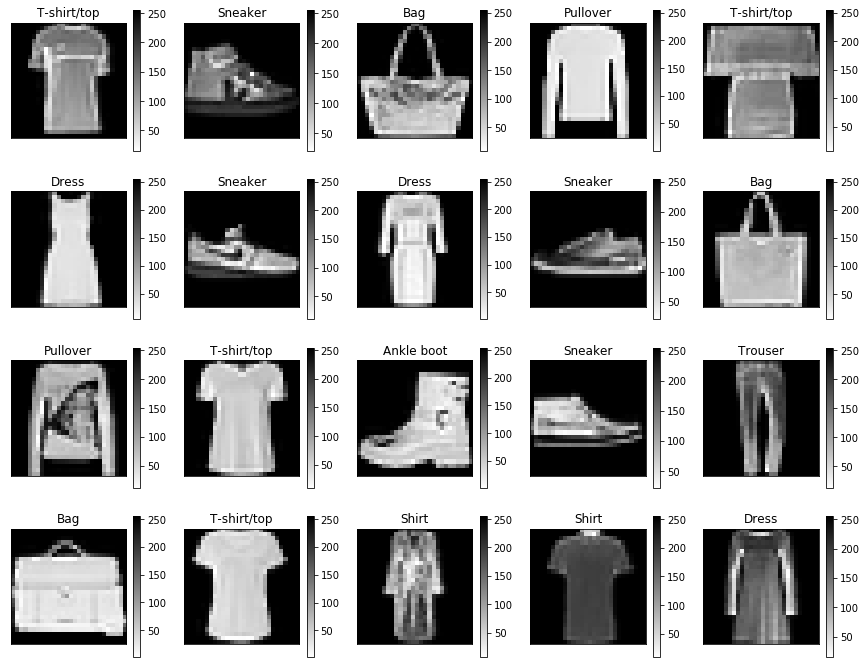

Generated Image Data which applied zooming, or width-shift/height-shift


In [57]:
from keras.preprocessing.image import ImageDataGenerator


gen = ImageDataGenerator(width_shift_range=0.005,height_shift_range=0.005,horizontal_flip=True)

base_model = Sequential([Conv2D(64, kernel_size=3, activation='relu',input_shape=(28,28,1)),
                          BatchNormalization(),
                          
                          Conv2D(64, kernel_size=3, activation='relu'),
                          MaxPooling2D(pool_size=2),
                          Dropout(0.3),
                          
                          Conv2D(128, kernel_size=3, activation='relu'),    
                          BatchNormalization(),
                          Dropout(0.5),

                          Flatten(),
                          Dense(128, activation='relu'),
                          BatchNormalization(),
                          Dropout(0.5),
                          Dense(10, activation='softmax')
                         ],name="base_model") 

base_model.summary()


base_model.compile(loss='sparse_categorical_crossentropy',
                       optimizer='adam',
                      metrics=['accuracy'])


batches = gen.flow(train_images, train_labels, batch_size=256)
val_batches = gen.flow(valid_images, valid_labels, batch_size=256)
augmentaion_model = base_model.fit_generator(batches, steps_per_epoch=60000//256, epochs=20,callbacks=[early_callback]
                    ,validation_data=val_batches,validation_steps=10000//256, use_multiprocessing=True)
x,y = batches.next()

plt.figure(figsize=(15,15))
for i in range(0,20):
    plt.subplot(5,5, i+1)
    image = 255- x[i].reshape(28,28)*255.0
    plt.imshow(image,cmap=plt.cm.binary)
    plt.title(labels[y[i]])
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.grid(False)
plt.show()

print ("Generated Image Data which applied zooming, or width-shift/height-shift")

In [64]:
base_model_loss, base_model_acc  = base_model.evaluate(test_images,test_labels, verbose=2)
print("Final model accuracy: %", base_model_acc) 

Final model accuracy: % 0.9284999966621399


Accuracy improved slightly.  We may reach better results by tuning with hyper-parameters like vertical-flip, lightning conditions, shift ranges.

In [13]:
# Visualize 

%matplotlib inline

def helper_plt(col,val,training_val,valid_val):
    xy[col].plot(epochs, training_val, color='orange', label='Training %s' % val)
    xy[col].plot(epochs, valid_val, color='magenta',label='Validation %s' % val)
    xy[col].set_title('Training & Validation %s' % val)
    xy[col].legend()
    xy[col].set_xlabel('Epochs')
    xy[col].set_ylabel('Loss')
    xy[col].grid(True)
    

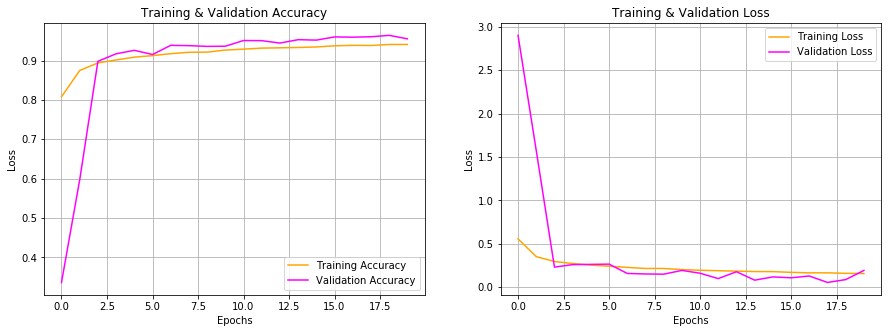

In [61]:
fig, xy = plt.subplots(1,2, figsize=(15, 5))
acc = augmentaion_model.history['accuracy']
val_accuracy = augmentaion_model.history['val_accuracy']
train_loss = augmentaion_model.history['loss']
val_loss = augmentaion_model.history['val_loss']
epochs = range(len(acc))
helper_plt(0,"Accuracy",acc,val_accuracy)
helper_plt(1,"Loss",train_loss,val_loss)
plt.show()


Training and validation data convergences that we may say the model is not over-fitting.

In [66]:
#%load_ext tensorboard
#%tensorboard --logdir logs/  --port=6006 --host=0.0.0.0
#You may play with TensorFlow Graph to examine model’s structure 
